<a href="https://colab.research.google.com/github/osama-obo-tnt/Quranic-Verses-OCR-and-string-matching/blob/main/Arabic_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install fuzzywuzzy
!pip install ArabicOcr
import pandas as pd
!pip install opencv-python
from fuzzywuzzy import fuzz
from ArabicOcr import arabicocr
from google.colab import files
import re
import time
import cv2
import numpy as np
from google.colab import drive
from IPython.display import HTML, display
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import time


# Mount Google Drive
drive.mount('/content/drive')

# Load the verified data (verses with diacritics) from a CSV file
csv_file_path = '/content/drive/MyDrive/Arabic-Original.csv'
verified_data = pd.read_csv(csv_file_path).iloc[:, 0].tolist()


# Initialize flag for image processing function
image_processing_initialized = False


# Function to remove diacritics from Arabic text
def remove_diacritics(text):
    diacritics = re.compile(r"[\u0617-\u061A\u064B-\u0652\u06D6-\u06DC\u06DF\u06E0-\u06E4\u06E7\u06E8\u06EA-\u06ED]")
    return diacritics.sub('', text)

# Function to preprocess the image
def preprocess_image(image_path):
    import cv2
    import numpy as np
    from google.colab.patches import cv2_imshow

    # Load the image
    image = cv2.imread(image_path)

    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Sharpening
    sharpening_kernel = np.array([[-1, -1, -1],
                                  [-1, 9, -1],
                                  [-1, -1, -1]])
    sharpened_image = cv2.filter2D(gray_image, -1, sharpening_kernel)

    # Brightness Correction
    brightened_image = cv2.convertScaleAbs(sharpened_image, alpha=1.5, beta=0)  # Adjust alpha and beta as needed

    # Contrast Adjustment
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    contrast_adjusted_image = clahe.apply(brightened_image)

    # Noise Reduction (Gaussian Blur)
    blurred_image = cv2.GaussianBlur(contrast_adjusted_image, (3, 3), 0)  # Adjust kernel size as needed

    # Thresholding
    _, thresholded_image = cv2.threshold(blurred_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Save the preprocessed image
    cv2.imwrite('/content/preprocessed_image.jpg', thresholded_image)

    # Load the preprocessed image
    final_image = cv2.imread('/content/preprocessed_image.jpg')

    # Display the image
    cv2_imshow(final_image)

    # Final image path
    final_image_path = '/content/preprocessed_image.jpg'

    return final_image_path

# Function to perform OCR and matching
def perform_ocr_and_match(image_path, verified_data):
    # Preprocess the image
    preprocessed_image_path = preprocess_image(image_path)

    # Extract text from the image
    extracted_text = arabicocr.arabic_ocr(preprocessed_image_path, 'out.png')

    # Access the text content from the inner list
    text_content = extracted_text[0][1]

    # Remove diacritics from the extracted text
    extracted_text_without_diacritics = remove_diacritics(text_content)

    # Remove diacritics from the verified verses
    verified_data_without_diacritics = [remove_diacritics(verse) for verse in verified_data]

    # Get the current time before the fuzzy string matching
    start_time = time.time()

    # Perform string matching with fuzzywuzzy
    matches = []
    threshold = 20  # Adjust the threshold as needed

    for verse, verse_without_diacritics in zip(verified_data, verified_data_without_diacritics):
        similarity = fuzz.ratio(extracted_text_without_diacritics, verse_without_diacritics)
        if similarity >= threshold:
            matches.append((verse, similarity))

    # Get the current time after the fuzzy string matching
    end_time = time.time()

    # Calculate the time taken
    time_taken = end_time - start_time

    # Sort the matches by similarity
    matches.sort(key=lambda x: x[1], reverse=True)

    # Return results
    return matches, time_taken

# Function to handle image upload and processing
def handle_image_upload(change):
    uploaded_files = files.upload()
    if uploaded_files:
        image_path = list(uploaded_files.keys())[0]
        matches, time_taken = perform_ocr_and_match(image_path, verified_data)

        # Styling for display
        display(HTML('<style>.output-image {background-color: #f7f7f7; padding: 10px; border-radius: 10px;}'
                     'h3 {color: #333;}</style>'))

        # Display results with styling
        display(HTML(f"<h3 style='color: #4CAF50;'>Time taken: {time_taken} seconds</h3>"))
        if matches:
            top_match = matches[0]
            display(HTML(f"<h3 style='color: #4CAF50;'>Top Match: {top_match[0]} (Similarity: {top_match[1]}%)</h3>"))
        else:
            display(HTML("<h3 style='color: #FF5733;'>No matches found.</h3>"))

# Function to handle text upload and processing
def handle_text_upload(change):
    uploaded_files = files.upload()
    if uploaded_files:
        text_path = list(uploaded_files.keys())[0]
        text = uploaded_files[text_path].decode('utf-8')
        matches, time_taken = perform_ocr_and_match(text, verified_data)

        # Styling for display
        display(HTML('<style>.output-text {background-color: #f7f7f7; padding: 10px; border-radius: 10px;}'
                     'h3 {color: #333;}</style>'))

        # Display results with styling
        display(HTML(f"<h3 style='color: #4CAF50;'>Time taken: {time_taken} seconds</h3>"))
        if matches:
            top_match = matches[0]
            display(HTML(f"<h3 style='color: #4CAF50;'>Top Match: {top_match[0]} (Similarity: {top_match[1]}%)</h3>"))
        else:
            display(HTML("<h3 style='color: #FF5733;'>No matches found.</h3>"))




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Saving fatiha.jpg to fatiha (1).jpg


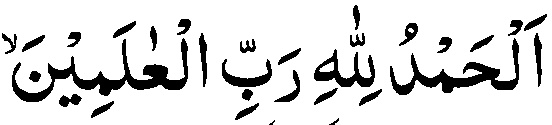

[INFO] OCR'ing input image...
Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete[INFO] 0.2526: العلمينًا
[INFO] 0.3827: آلحمد
[INFO] 0.2309: يله ربب


Saving verse.png to verse.png


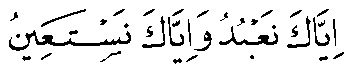

[INFO] OCR'ing input image...
[INFO] 0.1811: اناك نعبمدواناك نستعن


In [7]:
# Title
display(HTML("<h1 style='text-align: center; color: #;'>QURAN VERSE MATCHING OCR</h1>"))

# Centered Image upload section
display(HTML("<div style='text-align: center;'>"
             "<h2 style='color: #4CAF50;'>Upload Image</h2>"
             "</div>"))
# Centered Image upload button
image_upload_button = widgets.FileUpload(style={'color': '#fff', 'background-color': '#000', 'border': '3px solid #ddd', 'padding': '10px', 'border-radius': '10px'})
image_upload_button.observe(handle_image_upload, names='data')

# Center the button
centered_image_upload_button = widgets.HBox([widgets.Label(layout=widgets.Layout(flex='1')), image_upload_button, widgets.Label(layout=widgets.Layout(flex='1'))])

# Display the centered button
display(centered_image_upload_button)

# Centered Image upload section
display(HTML("<div style='text-align: center;'>"
             "<h2 style='color: black;'>Result:</h2>"
             "</div>"))
